# Supervised Learning Project: Finding Donors for CharityML

## Objective

In this project, we will test out several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## Exploring the Data

Let's start with importing the necessary libaries, reading in the data, and checking out the dataset.

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:

#Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display

#Import vishualizing libraries

import seaborn as sns
import matplotlib.pyplot as plt

#Pretty display for notebooks
%matplotlib inline

from __future__ import division

#Load the Census dataset
data = pd.read_csv('data/adult.csv')

#Display the first record
display(data.head(3))

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


A simple investigation of the dataset can determine how many individuals fit into either group, and tell us about the percentage of these individuals making more than $50,000.

In [2]:
#Checking out the datatypes features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Let's take a look at the following:
* The total number of records, `'n_records'`
* The number of individuals making more than  50,000 annually, `'n_greater_50k'`.
* The number of individuals making at most 50,000 annually, `'n_at_most_50k'`.
* The percentage of individuals making more than 50,000 annually, `'greater_percent'`.

In [3]:
#TODO: Total number of records
n_records = len(data)

#TODO: The number of individuals making more than $50,000
n_greater_50k = len(data[data['income']=='>50K'])

#TODO: The number of individuals making at most $50,000
n_at_most_50k = len(data[data['income']=='<=50K'])

#TODO: The percentage of individuals making more than $50,000
greater_percent = 100 * n_greater_50k / n_records

#Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50k: {}".format(n_greater_50k))
print ("Individuals making at most $50k: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))


Total number of records: 32561
Individuals making more than $50k: 7841
Individuals making at most $50k: 24720
Percentage of individuals making more than $50,000: 24.08%


We can also visualize the relationship between different features of an individual, and their incomes.

Let's see breakdown of the counts of people earning above or below 50K based on their sex and education levels.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


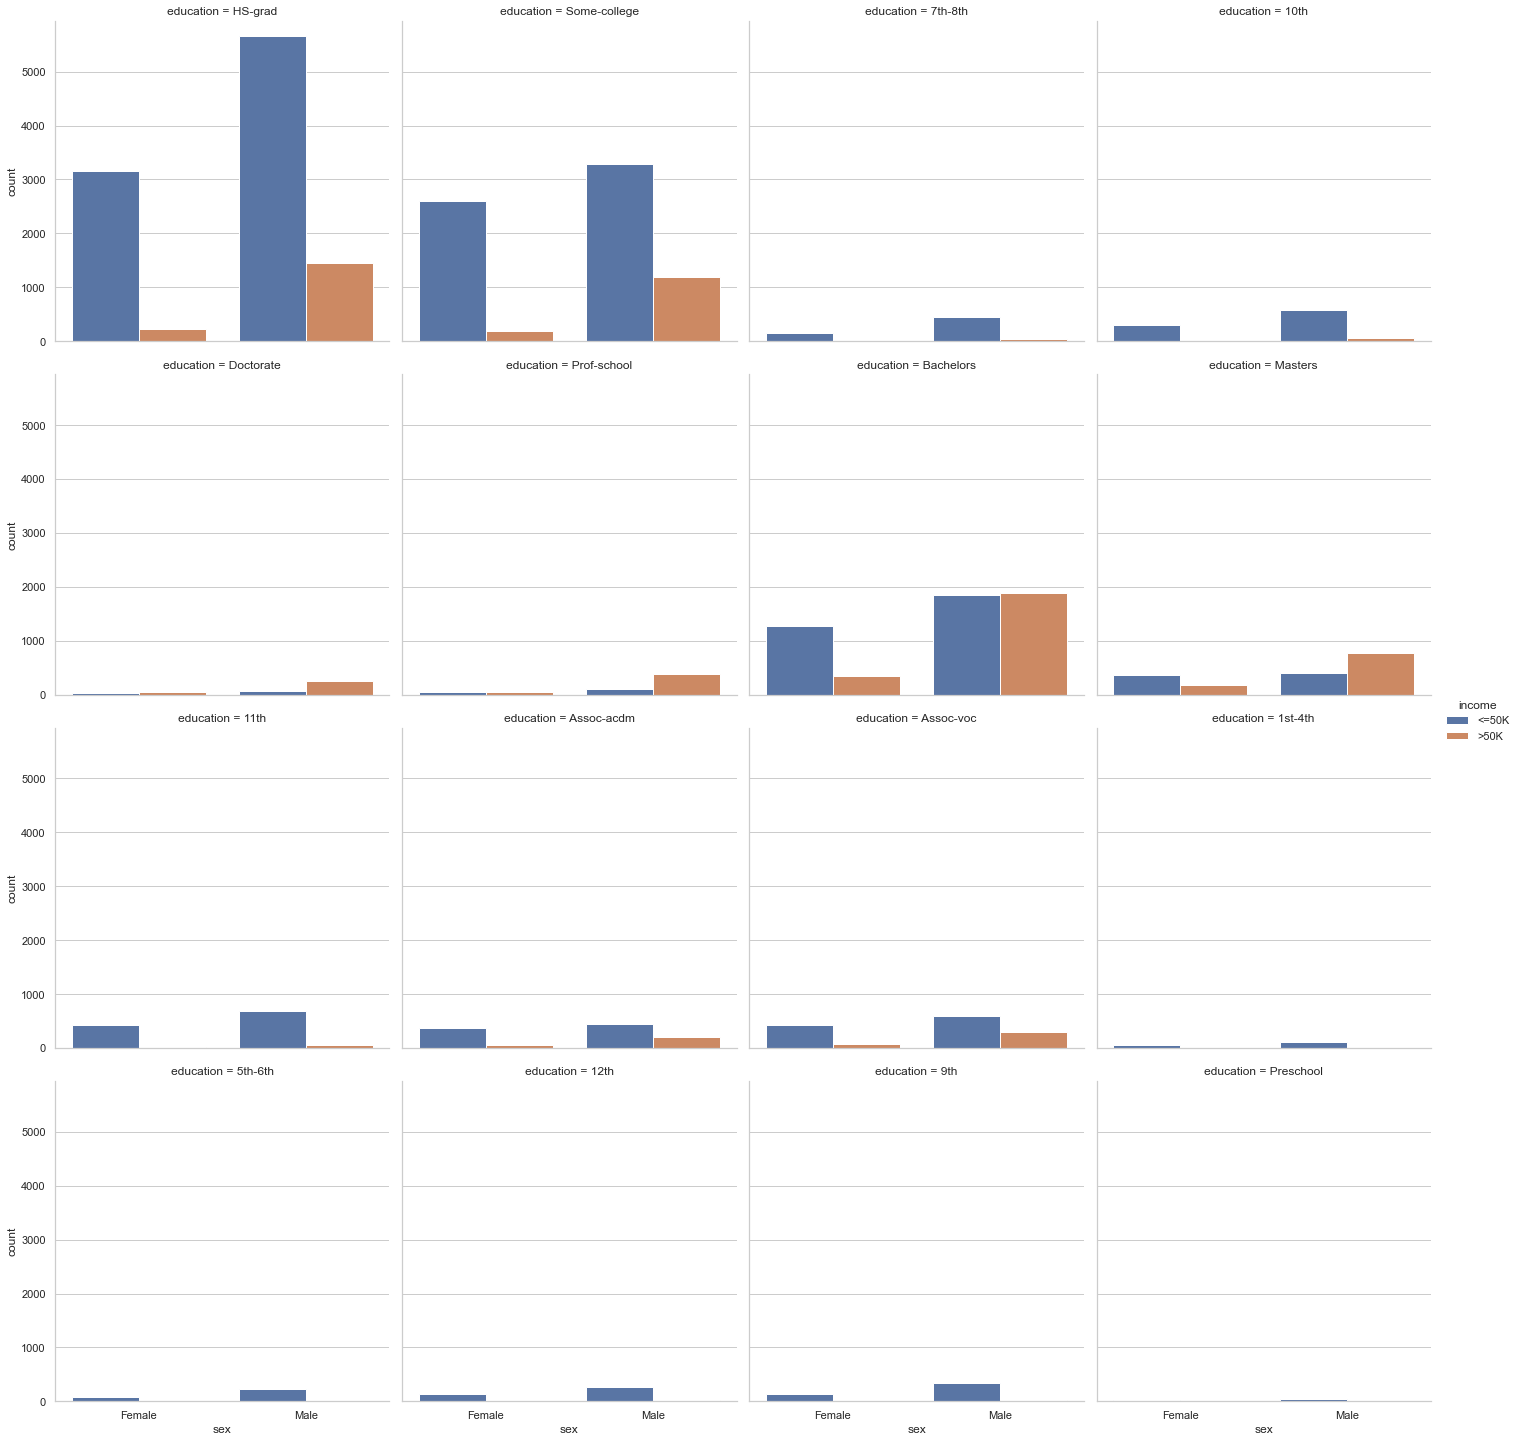

In [4]:
sns.set(style='whitegrid',color_codes=True)
sns.catplot("sex",col='education',data=data,hue='income',kind='count',col_wrap=4)

## Preparing the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [5]:
#Split the data into features and target label
income_raw = data['income']
feature_raw = data.drop('income',axis=1)

Text(0.5, 1.0, "'Capital-gain' Feature Distribution")

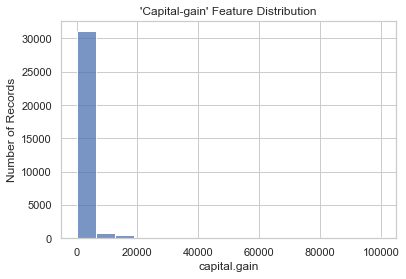

In [6]:
sns.histplot(data=data, x='capital.gain')
plt.ylabel('Number of Records')
plt.title("'Capital-gain' Feature Distribution")

Text(0.5, 1.0, "'Capital-loss' Feature Distribution")

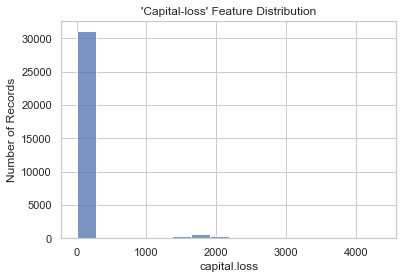

In [7]:
sns.histplot(data=data, x='capital.loss')
plt.ylabel('Number of Records')
plt.title("'Capital-loss' Feature Distribution")

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers.

In [8]:
#Log-transform the skewed features
skewed = ['capital.gain','capital.loss']
feature_raw[skewed] = data[skewed].apply(lambda x: np.log(x+1))

## Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [9]:
#Importing processing techniques
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
minmax = MinMaxScaler()
features = ['age','education.num','capital.gain','capital.loss','hours.per.week']
feature_raw[features] = minmax.fit_transform(data[features])

#Example of record with scaling applied
display(feature_raw.head(3))

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.000000,?,77053,HS-grad,0.533333,Widowed,?,Not-in-family,White,Female,0.0,1.0,0.397959,United-States
1,0.890411,Private,132870,HS-grad,0.533333,Widowed,Exec-managerial,Not-in-family,White,Female,0.0,1.0,0.173469,United-States
2,0.671233,?,186061,Some-college,0.600000,Widowed,?,Unmarried,Black,Female,0.0,1.0,0.397959,United-States


## Data Preprocessing

From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, 'income' to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [10]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
feat = pd.get_dummies(feature_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encode = list(feat.columns)
print ("{} total features after one-hot encoding".format(len(encode)))

108 total features after one-hot encoding


## Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split as TTS

# Split the 'features' and 'income' data into training and testing sets
x_train,x_test,y_train,y_test = TTS(feat,income,
                                   test_size=0.2,
                                   random_state=1)

# Show the results of the split
print ("Training has {} samples".format(x_train.shape[0]))
print ("Testing has {} samples".format(x_test.shape[0]))

Training has 26048 samples
Testing has 6513 samples


## Evaluating Model Performance

Now we will investigate four different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor

CharityML, equipped with their research, knows individuals that make more than  50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than  50,000 accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that does not make more than  50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than 50,000 is more important than the model's ability to recall those individuals. We can use F-beta score as a metric that considers both precision and recall

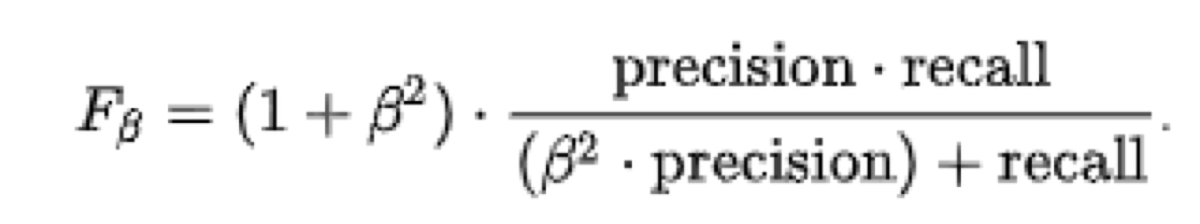

In particular, when `$\beta = 0.5$`, more emphasis is placed on precision.

Looking at the distribution of classes (those who make at most 50,000, and those who make more), it's clear most individuals do not make more than 50,000. This can greatly affect accuracy, since we could simply say "this person does not make more than 50,000" and generally be right, without ever looking at the data! Making such a statement would be called naive, since we have not considered any information to substantiate the claim. It is always important to consider the naive prediction for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than 50,000, CharityML would identify no one as donors.

What if we chose a model that always predicted an individual made more than $50,000, what would that model's accuracy and F-score be on this dataset?

### Naive Predictor Performace

In [12]:
# TODO: Calculate accuracy
accuracy = n_greater_50k / n_records

# Calculating precision
precision = n_greater_50k / (n_greater_50k + n_greater_50k)

#Calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1 * (0.5*0.5)) * (precision * recall / ((0.5*0.5 * (precision)) + recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy,fscore))

Naive Predictor: [Accuracy score: 0.2408, F-score: 0.1111]


## Supervised Learning Models

### Model Application

Now we'll pick three supervised learning models above that are appropriate for this problem, and test them on the census data.

#### Decision Trees

* Real world application: Decision Trees and, in general, CART (Classification and Regression Trees) are often used in financial analysis.
* Strengths:
 - Able to handle categorical and numerical data.
 - Doesn't require much data pre-processing, and can handle data which hasn't been normalized, or encoded for Machine Learning Suitability.
 - Simple to understand and interpret.
* Weaknesses:
 - Complex Decision Trees do not generalize well to the data and can result in overfitting.
 - Unstable, as small variations in the data can result in a different decision tree. Hence they are usually used in an ensemble (like Random Forests) to build robustness.
 - Can create biased trees if some classes dominate.
* Candidacy: Since a decision tree can handle both numerical and categorical data, it's a good candidate for our case (although, the pre-processing steps might already mitigate whatever advantage we would have had). It's also easy to interpret, so we will know what happens under the hood to interpret the results.

#### Support Vector Machines (SVM)

* Real world application: Example of a real world use of SVMs include image classification and image segmentation.
* Strenghs:
 -  Effective in high dimensional spaces, or when there are a lot of features.
 -  Kernel functions can be used to adapt to different cases, and can be completely customized if needed. Thus SVMs are versatile.
* Weaknesses:
 - Doesn't perform well with large datasets.
 - Doesn't directly provide probability estimates.
* Candidacy: SVMs were chosen because of their effectiveness given high dimensionality. After incorporating dummy variables, we have more than 100 features in our dataset, so SVMs should be a classifier that works regardless of that. Also, our dataset is not that large to be a deterrent.

#### Ensemble methods: AdaBoost

* Real world application: Ensemble methods are used extensively in Kaggle competitions, usually in image detection. A real world example of Adaboost is object detection in image.
* Strength:
 - Ensemble methods, including Adaboost are more robust than single estimators, have improved generalizability.
 - Simple models can be combined to build a complex model, which is computationally fast.
* Weaknesses:
 - If we have a biased underlying classifier, it will lead to a biased boosted model.
* Candidacy: Ensemble methods are considered to be high quality classifiers, and adaboost is the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

## Creating a Training and Predicting Pipeline

To properly evaluate the performance of each model we've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [13]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, x_train, y_train, x_test, y_test):
    
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() #Get start time
    learner = learner.fit(x_train[:sample_size],y_train[:sample_size])
    end = time() #Get time start

    # TODO: Calculate the training time
    results['train_time'] = end - start
    
    # TODO: Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() #Get start time
    prediction_test = learner.predict(x_test)
    prediction_train = learner.predict(x_train[:300])
    end = time() #Get start time
    
    # TODO: Calculate the total prediction time
    results['predict_time'] = end - start
    
    # TODO: Compute accuracy on the first 300 training samples
    results['accuracy_train'] = accuracy_score(y_train[:300],prediction_train)
    
    # TODO: Compute accuracy on test set
    results['accuracy_test'] = accuracy_score(y_test,prediction_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],prediction_train,0.5)
    
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,prediction_test,0.5)
    
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    #Return the results
    return results

## Model Evaluation

Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance (both on the test, and training sets).

In [14]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier as ADA

# TODO: Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = DTC(random_state = 101)
clf_B = SVC(random_state = 101)
clf_C = ADA(random_state = 101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
sample_1 = int(round(len(x_train)/100))
sample_10 = int(round(len(x_train)/10))
sample_100 = len(x_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([sample_1, sample_10, sample_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, x_train, y_train, x_test, y_test)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


DecisionTreeClassifier trained on 260 samples.
DecisionTreeClassifier trained on 2605 samples.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


DecisionTreeClassifier trained on 26048 samples.
SVC trained on 260 samples.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


SVC trained on 2605 samples.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


SVC trained on 26048 samples.
AdaBoostClassifier trained on 260 samples.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


AdaBoostClassifier trained on 2605 samples.
AdaBoostClassifier trained on 26048 samples.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [15]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%',1:'10%',2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
train_time,0.007135,0.023844,0.504358
predict_time,0.014403,0.008464,0.012878
accuracy_train,0.976667,1.000000,1.000000
accuracy_test,0.789037,0.808537,0.819131
f_train,0.955679,1.000000,1.000000
f_test,0.565339,0.604152,0.624841


SVC


,1%,10%,100%
train_time,0.013456,0.637689,63.994943
predict_time,0.152415,1.292520,12.182577
accuracy_train,0.756667,0.756667,0.756667
accuracy_test,0.758944,0.758944,0.758944
f_train,0.000000,0.000000,0.000000
f_test,0.000000,0.000000,0.000000


AdaBoostClassifier


,1%,10%,100%
train_time,0.072583,0.256679,2.736124
predict_time,0.104724,0.092460,0.123807
accuracy_train,0.933333,0.893333,0.873333
accuracy_test,0.822969,0.856902,0.861815
f_train,0.879765,0.809061,0.757098
f_test,0.633252,0.710983,0.730981


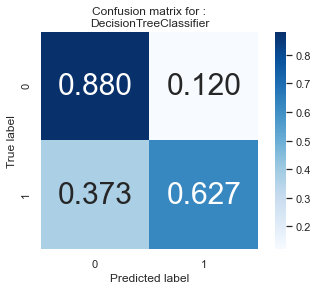

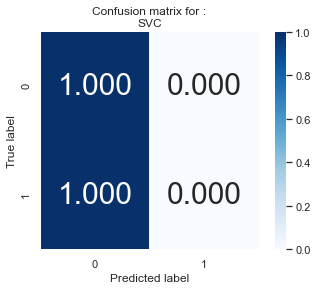

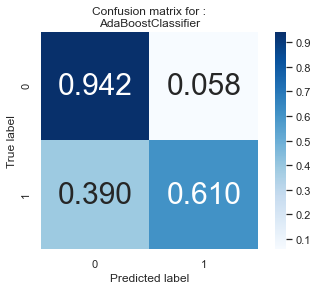

In [16]:
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(x_test))
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    plt.figure(i)
    sns.heatmap(cm,annot=True, annot_kws={'size':30},
            cmap="Blues", square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for :\n{}'.format(model.__class__.__name__));

Looking at the results above, out of the three models, AdaBoost is the most appropriate for our task.

First and foremost, it is the classifier that performs the best on the testing data, in terms of both the accuracy and f-score. It also takes resonably low time to train on the full dataset, which is just a fraction of the 120 seconds taken by SVM, the next best classifier to train on the full training set. So it should scale well even if we have more data.

By default, Adaboost uses a decision stump i.e. a decision tree of depth 1 as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

### But how does Adaboost work?
1. Adaboost works by combining several simple learners (for ex: decision trees), to create an ensemble of learners that can predict whether an individual earns above 50k or not.

2. Each of the learners, in our case decision trees, are created using "features" we have about individuals (eg. age, occupation, education, etc) create a set of rules that can predict a person's income.

3. During the training process, which lasts for several rounds, the Adaboost algorithm looks at instances where it has predicted badly, and prioritizes the correct prediction of those instances in the next round of raining.

4. With each round, the model finds the best learner (or decision tree) to incorporate into the ensemble, repeating the process for the specified number of rounds, or till we can't improve the predictions further.

5. All the learners are then combined to make a final ensembled model, where they each vote to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

6. Using this model with the census information of individuals, we can predict the same information for a potential new donor and predict if they earn more than 50K or not, and thus make a decision on the likeliness of them donating to charity.

## Improving our Model: Model Tuning

Using grid search (`GridSearchCV`) with different parameter/value combinations, we can tune our model for even better results.

For Adaboost, we'll tune the n_estimators and learning rate parameters, and also the base classifier paramters (remember our base classifier for the Adaboost ensemble is a Decision tree!).

In [ ]:
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import make_scorer

clf = ADA(base_estimator=DTC())

parameters = {'n_estimators':[50, 120],
              'learning_rate':[0.1,0.5,1.],
              'base_estimator__min_samples_split': np.arange(2,8,2),
              'base_estimator__max_depth':np.arange(1,4,1)
             }

scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GSCV(clf, parameters,scorer)

grid_fit = grid_obj.fit(x_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = best_clf.predict(x_test)

print ("Unoptimized model\n-----")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Final Model Evaluation
**Results**:


The optimized model has an accuracy of 0.8702 and F-score of 0.7526.

These scores are better than the umpotimized model, while being substantially better than the benchmark predictor.